# Step 1 – Import Required Libraries

In [1]:
import os
from typing import List, Sequence
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.optimize import least_squares
from pathlib import Path
import math
from scipy.ndimage import zoom, shift, gaussian_filter, map_coordinates, affine_transform
from numpy import gradient

# 1 Coregistration of the input to the reference image

These functions serve as helper utilities to support 3D rigid coregistration of medical image volumes. centroid calculation, gradient magnitude extraction, and basic volume visualization. 

In [ ]:
# Format a sequence of floats into a string with 2 decimal precision
def str_floats(sequence_of_floats: Sequence[float]) -> str:
    return f'({", ".join([f"{coord:0.02f}" for coord in sequence_of_floats])})'

# Format a quaternion as a string
def str_quaternion(q: tuple[float, float, float, float]) -> str:
    if not q:
        return '[None]'
    return f'{q[0]} + {q[1]}i + {q[2]}j + {q[3]}k'

# Multiply two quaternions
def multiply_quaternions(q1: tuple[float, float, float, float], q2: tuple[float, float, float, float]) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    return (
        q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3],
        q1[0] * q2[1] + q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2],
        q1[0] * q2[2] - q1[1] * q2[3] + q1[2] * q2[0] + q1[3] * q2[1],
        q1[0] * q2[3] + q1[1] * q2[2] - q1[2] * q2[1] + q1[3] * q2[0]
    )

# Return the conjugate of a quaternion
def conjugate_quaternion(q: tuple[float, float, float, float]) -> tuple[float, float, float, float]:
    """ Compute the conjugate of a quaternion (1, i, j, k). """
    return (q[0], -q[1], -q[2], -q[3])

# Rotate a 3D point using quaternion rotation
def rotate_point_by_quaternion(point: tuple[float, float, float], q_rot: tuple[float, float, float, float]) -> tuple[float, float, float]:
    """ Rotate a 3D point using a quaternion. """
    p = (0.0, point[0], point[1], point[2])  # Convert point to pure quaternion
    q_rot_conj = conjugate_quaternion(q_rot)
    p_prime = multiply_quaternions(q_rot, multiply_quaternions(p, q_rot_conj))
    return (p_prime[1], p_prime[2], p_prime[3])

# Construct a rotation quaternion from an angle and an axis
def create_rotation_quaternion(angle_in_rads: float, axis_x: float, axis_y: float, axis_z: float) -> tuple[float, float, float, float]:
    """ Create a rotation quaternion from an angle and axis. """
    norm = math.sqrt(axis_x**2 + axis_y**2 + axis_z**2)
    if norm == 0:
        return (1.0, 0.0, 0.0, 0.0)  # Identity rotation
    axis_x, axis_y, axis_z = axis_x / norm, axis_y / norm, axis_z / norm
    cos_half_angle = math.cos(angle_in_rads / 2)
    sin_half_angle = math.sin(angle_in_rads / 2)
    return (cos_half_angle, sin_half_angle * axis_x, sin_half_angle * axis_y, sin_half_angle * axis_z)

# Translate a point by a vector
def translation(point: tuple[float, float, float], translation_vector: tuple[float, float, float]) -> tuple[float, float, float]:
    """ Perform translation of `point` by `translation_vector`. """
    x, y, z = point
    v1, v2, v3 = translation_vector
    return (x + v1, y + v2, z + v3)

# Crop the center of a 3D volume to the specified dimensions
def center_crop(vol, dim):
    """Returns center cropped volume (only crops, does not pad)."""
    X, Y, Z = vol.shape
    crop_x, crop_y, crop_z = dim[0], dim[1], dim[2]

    start_x = max(0, (X - crop_x) // 2)
    end_x = min(start_x + crop_x, X)
    start_x = max(0, end_x - crop_x)

    start_y = max(0, (Y - crop_y) // 2)
    end_y = min(start_y + crop_y, Y)
    start_y = max(0, end_y - crop_y)

    start_z = max(0, (Z - crop_z) // 2)
    end_z = min(start_z + crop_z, Z)
    start_z = max(0, end_z - crop_z)

    return vol[start_x:end_x, start_y:end_y, start_z:end_z]

# Pad a 3D volume to the target shape, center-aligned
def center_pad(vol, dim):
    """Returns center aligned padded volume. Also crops if vol is larger than dim."""
    X, Y, Z = vol.shape
    pad_x, pad_y, pad_z = dim

    if X > pad_x or Y > pad_y or Z > pad_z:
        vol = center_crop(vol, dim)
        X, Y, Z = vol.shape

    larger_vol = np.zeros(dim, dtype=vol.dtype)
    start_x = (pad_x - X) // 2
    start_y = (pad_y - Y) // 2
    start_z = (pad_z - Z) // 2

    larger_vol[start_x:start_x+X, start_y:start_y+Y, start_z:start_z+Z] = vol
    return larger_vol

# Compute mutual information between two images
def mutual_information(img_input: np.ndarray, img_reference: np.ndarray) -> np.ndarray:
    """ Compute the Shannon Mutual Information between two images. """
    nbins = [50, 50]
    hist_input, _ = np.histogram(img_input.ravel(), bins=nbins[0])
    prob_distr_input = hist_input / (np.sum(hist_input) + 1e-7)
    entropy_input = -np.sum(prob_distr_input * np.log2(prob_distr_input + 1e-7))

    hist_reference, _ = np.histogram(img_reference.ravel(), bins=nbins[1])
    prob_distr_reference = hist_reference / (np.sum(hist_reference) + 1e-7)
    entropy_reference = -np.sum(prob_distr_reference * np.log2(prob_distr_reference + 1e-7))

    joint_hist, _, _ = np.histogram2d(img_input.ravel(), img_reference.ravel(), bins=nbins)
    prob_distr_joint = joint_hist / (np.sum(joint_hist) + 1e-7)
    joint_entropy = -np.sum(prob_distr_joint * np.log2(prob_distr_joint + 1e-7))

    return entropy_input + entropy_reference - joint_entropy

# Compute negative mutual information as a residual loss
def vector_of_residuals(ref_volume: np.ndarray, inp_volume_transformed: np.ndarray) -> float:
    """ Compute residual value between transformed input and reference using mutual information. """
    if inp_volume_transformed.shape != ref_volume.shape:
        print(f"DEBUG: Reshaping transformed input from {inp_volume_transformed.shape} to target {ref_volume.shape}")
        inp_volume_transformed_matched = center_pad(inp_volume_transformed, ref_volume.shape)
    else:
        inp_volume_transformed_matched = inp_volume_transformed

    return -mutual_information(inp_volume_transformed_matched, ref_volume)

# Normalize volume values to [0, 1]
def min_max_normalize(vol: np.ndarray):
    """ Normalizes the input volume to range [0, 1]. """
    amin = np.amin(vol)
    amax = np.amax(vol)
    if amax == amin:
        return np.zeros_like(vol, dtype=np.float32)
    return (vol - amin) / (amax - amin)


def rigid_transformation(volume: np.ndarray, parameters: tuple[float, ...], ref_volume_shape: tuple):
    """Apply translation, rotation (via quaternion), and scaling to `volume`, based on `parameters`."""
    # Unpack transformation parameters
    t1, t2, t3, v1, v2, v3, angle_param, s1, s2, s3 = parameters
    
    # Scale the parameters to physical transformation ranges
    scaled_t1, scaled_t2, scaled_t3 = np.array([t1, t2, t3])*40 - 20 
    scaled_angle_rads = angle_param * (2 * np.pi)
    scaled_s1, scaled_s2, scaled_s3 = np.array([s1, s2, s3])*0.1 + 0.9

    temp_volume = volume.astype(np.float32)

    # Apply translation
    temp_volume = shift(temp_volume, (scaled_t1, scaled_t2, scaled_t3), order=1, mode='nearest')
    
    # Compute center of volume for rotation
    center = np.array([d / 2 for d in temp_volume.shape])
    
    # Normalize rotation axis and create quaternion
    axis_rot_norm = math.sqrt(v1**2 + v2**2 + v3**2)
    if axis_rot_norm < 1e-7:
        q_rot = (1.0, 0.0, 0.0, 0.0)  # No rotation
    else:
        q_rot = create_rotation_quaternion(scaled_angle_rads, v1 / axis_rot_norm, v2 / axis_rot_norm, v3 / axis_rot_norm)

    # Convert quaternion to rotation matrix
    q0, q1, q2, q3 = q_rot
    rot_matrix = np.array([
        [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
    ])
    
    # Rotate around volume center
    rot_matrix_for_affine = rot_matrix.T
    offset_rot = center - np.dot(rot_matrix_for_affine, center)
    temp_volume = affine_transform(temp_volume, matrix=rot_matrix_for_affine, offset=offset_rot, order=1, mode='nearest')

    # Apply scaling
    temp_volume = zoom(temp_volume, (scaled_s1, scaled_s2, scaled_s3), order=1, mode='nearest') 

    # Pad or crop to match reference volume shape
    t_volume = center_pad(temp_volume, ref_volume_shape)
    
    return t_volume.astype(volume.dtype)


def inverse_rigid_transformation(volume: np.ndarray, parameters: tuple[float, ...], ref_volume_shape: tuple):
    """Apply the inverse transformation of `parameters` to `volume`."""
    # Unpack and scale parameters (as above)
    t1, t2, t3, v1, v2, v3, angle_param, s1, s2, s3 = parameters
    scaled_t1, scaled_t2, scaled_t3 = np.array([t1, t2, t3])*40 - 20
    scaled_s1, scaled_s2, scaled_s3 = np.array([s1, s2, s3])*0.1 + 0.9
    scaled_angle_rads = angle_param * (2 * np.pi)

    temp_volume = volume.astype(np.float32)

    # Invert scaling
    temp_volume = zoom(temp_volume, (1/scaled_s1, 1/scaled_s2, 1/scaled_s3), order=1, mode='nearest')

    center = np.array([d / 2 for d in temp_volume.shape])

    # Compute inverse quaternion (conjugate)
    axis_rot_norm = math.sqrt(v1**2 + v2**2 + v3**2)
    if axis_rot_norm < 1e-7:
        q_rot = (1.0, 0.0, 0.0, 0.0)
    else:
        q_rot = create_rotation_quaternion(scaled_angle_rads, v1 / axis_rot_norm, v2 / axis_rot_norm, v3 / axis_rot_norm)
    q_rot_inv = conjugate_quaternion(q_rot)

    # Convert to inverse rotation matrix
    q0_inv, q1_inv, q2_inv, q3_inv = q_rot_inv
    rot_matrix_inv = np.array([
        [1 - 2*(q2_inv**2 + q3_inv**2), 2*(q1_inv*q2_inv - q0_inv*q3_inv), 2*(q1_inv*q3_inv + q0_inv*q2_inv)],
        [2*(q1_inv*q2_inv + q0_inv*q3_inv), 1 - 2*(q1_inv**2 + q3_inv**2), 2*(q2_inv*q3_inv - q0_inv*q1_inv)],
        [2*(q1_inv*q3_inv - q0_inv*q2_inv), 2*(q2_inv*q3_inv + q0_inv*q1_inv), 1 - 2*(q1_inv**2 + q2_inv**2)]
    ])
    
    # Rotate back
    offset_rot_inv = center - np.dot(rot_matrix_inv, center)
    temp_volume = affine_transform(temp_volume, matrix=rot_matrix_inv, offset=offset_rot_inv, order=1, mode='nearest')
    
    # Reverse translation
    temp_volume = shift(temp_volume, (-scaled_t1, -scaled_t2, -scaled_t3), order=1, mode='nearest')

    # Pad/crop back to original shape
    t_volume = center_pad(temp_volume, ref_volume_shape)
    
    return t_volume.astype(volume.dtype)


def calculate_volume_centroid(volume: np.ndarray, metadata) -> np.ndarray:
    # Extract voxel spacing and origin info from metadata
    pixel_spacing_y, pixel_spacing_x = metadata.PixelSpacing
    slice_thickness = metadata.SliceThickness
    image_position_patient = np.array(metadata.ImagePositionPatient)

    # Define voxel indices in each dimension
    z_coords_voxel = np.arange(volume.shape[0])
    y_coords_voxel = np.arange(volume.shape[1])
    x_coords_voxel = np.arange(volume.shape[2])

    # Convert voxel indices to physical (mm) coordinates
    physical_x_coords = image_position_patient[0] + x_coords_voxel * pixel_spacing_x
    physical_y_coords = image_position_patient[1] + y_coords_voxel * pixel_spacing_y
    physical_z_coords = image_position_patient[2] + z_coords_voxel * slice_thickness

    # Create 3D coordinate grids
    Z_grid, Y_grid, X_grid = np.meshgrid(physical_z_coords, physical_y_coords, physical_x_coords, indexing='ij')

    total_intensity = np.sum(volume)
    
    if total_intensity == 0:
        # Fallback: return center of volume in physical space
        center_voxel = np.array(volume.shape) / 2.0
        center_x = image_position_patient[0] + (center_voxel[2] * pixel_spacing_x)
        center_y = image_position_patient[1] + (center_voxel[1] * pixel_spacing_y)
        center_z = image_position_patient[2] + (center_voxel[0] * slice_thickness)
        return np.array([center_x, center_y, center_z])

    # Intensity-weighted centroid computation
    centroid_x = np.sum(volume * X_grid) / total_intensity
    centroid_y = np.sum(volume * Y_grid) / total_intensity
    centroid_z = np.sum(volume * Z_grid) / total_intensity

    return np.array([centroid_x, centroid_y, centroid_z])


def get_physical_coords_grid(shape: tuple, metadata) -> np.ndarray:
    """
    Create a 3D grid of physical coordinates (in mm) for a volume of given shape.
    Output shape: (Z, Y, X, 3), where last dim contains (x, y, z).
    """
    pixel_spacing_y, pixel_spacing_x = metadata.PixelSpacing
    slice_thickness = metadata.SliceThickness
    image_position_patient = np.array(metadata.ImagePositionPatient)

    z_indices = np.arange(shape[0])
    y_indices = np.arange(shape[1])
    x_indices = np.arange(shape[2])

    physical_x_coords = image_position_patient[0] + x_indices * pixel_spacing_x
    physical_y_coords = image_position_patient[1] + y_indices * pixel_spacing_y
    physical_z_coords = image_position_patient[2] + z_indices * slice_thickness

    # Note: indexing='ij' matches (Z, Y, X) order
    X_grid, Y_grid, Z_grid = np.meshgrid(physical_x_coords, physical_y_coords, physical_z_coords, indexing='ij')
    return np.stack([X_grid, Y_grid, Z_grid], axis=-1)


def physical_to_voxel_coords(physical_point: np.ndarray, metadata) -> np.ndarray:
    """
    Convert a physical (mm) point to floating-point voxel coordinates (z, y, x).
    """
    pixel_spacing_y, pixel_spacing_x = metadata.PixelSpacing
    slice_thickness = metadata.SliceThickness
    image_position_patient = np.array(metadata.ImagePositionPatient)

    x_p, y_p, z_p = physical_point
    x_v = (x_p - image_position_patient[0]) / pixel_spacing_x
    y_v = (y_p - image_position_patient[1]) / pixel_spacing_y
    z_v = (z_p - image_position_patient[2]) / slice_thickness

    return np.array([z_v, y_v, x_v])


def coregister_volumes_gradient_optimized(ref_volume: np.ndarray, ref_meta, inp_volume: np.ndarray, inp_meta):
    """
    Register two volumes using intensity gradient similarity and least-squares optimization.
    """
    print("\nPreparing volumes for gradient-based registration...")
    
    # Cast to float and smooth both volumes
    ref_volume_float = ref_volume.astype(np.float32)
    inp_volume_float = inp_volume.astype(np.float32)
    sigma_smoothing = 1.0
    
    smoothed_ref_volume = gaussian_filter(ref_volume_float, sigma=sigma_smoothing, mode='nearest')
    smoothed_inp_volume = gaussian_filter(inp_volume_float, sigma=sigma_smoothing, mode='nearest')

    # Compute gradients
    grad_z_ref, grad_y_ref, grad_x_ref = np.gradient(smoothed_ref_volume)
    grad_z_inp, grad_y_inp, grad_x_inp = np.gradient(smoothed_inp_volume)

    # Gradient magnitude and normalization
    ref_gradient_magnitude = np.sqrt(grad_z_ref**2 + grad_y_ref**2 + grad_x_ref**2)
    inp_gradient_magnitude = np.sqrt(grad_z_inp**2 + grad_y_inp**2 + grad_x_inp**2)
    
    ref_gradient_magnitude = min_max_normalize(ref_gradient_magnitude)
    inp_gradient_magnitude = min_max_normalize(inp_gradient_magnitude)

    # Use original volumes to compute physical centroids as initial alignment reference
    print("Calculating centroids for initial guess (using original physical metadata for accuracy)...")
    centroid_ref_mm = calculate_volume_centroid(globals()['ref_volume_orig'], globals()['ref_meta_orig'])
    centroid_inp_mm = calculate_volume_centroid(globals()['inp_volume_orig'], globals()['inp_meta_orig'])

    print(f"Reference Volume Centroid (x,y,z): {str_floats(centroid_ref_mm)} mm")
    print(f"Input Volume Centroid (x,y,z): {str_floats(centroid_inp_mm)} mm")

    # Initialize transformation parameters (identity transform)
    initial_parameters = [
        0.5, 0.5, 0.5,  # translation
        0.0, 0.0, 1.0,  # rotation axis
        0.0,            # rotation angle (rad)
        1.0, 1.0, 1.0   # scaling
    ]

    print(f"\nInitial Parameters for Optimization (Scaled for [0,1] range - Identity Transform):")
    print(f"  Translation (t1,t2,t3): ({initial_parameters[0]:.2f}, {initial_parameters[1]:.2f}, {initial_parameters[2]:.2f})")
    print(f"  Rotation Axis (v1,v2,v3): ({initial_parameters[3]:.2f}, {initial_parameters[4]:.2f}, {initial_parameters[5]:.2f})")
    print(f"  Rotation Angle (param): {initial_parameters[6]:.2f}")
    print(f"  Scaling (s1,s2,s3): ({initial_parameters[7]:.2f}, {initial_parameters[8]:.2f}, {initial_parameters[9]:.2f})")

    # Cost function using sum of squared differences (SSD) of gradient magnitude
    def cost_function_gradient_ssd(parameters):
        transformed_inp_gradient_magnitude = rigid_transformation(
            inp_gradient_magnitude, parameters, ref_gradient_magnitude.shape
        )
        residuals = ref_gradient_magnitude.flatten() - transformed_inp_gradient_magnitude.flatten()
        return residuals

    # Optimize parameters using Levenberg-Marquardt variant of least squares
    print("\nStarting gradient-based optimization with least_squares...")
    result = least_squares(
        cost_function_gradient_ssd,
        x0=initial_parameters,
        bounds=([0.0]*10, [1.0]*10),
        verbose=2,
        max_nfev=200,
        ftol=1e-6,
        xtol=1e-6,
        gtol=1e-6,
    )
    print("Optimization complete.")
    return result


def median_axial_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the 3D image (Z-Y plane, slice along X-axis). """
    if img_dcm.shape[0] == 0: return np.array([[]])
    return img_dcm[img_dcm.shape[0]//2, :, :]
    
def median_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the 3D image (Z-Y plane, slice along X-axis). """
    if img_dcm.shape[2] == 0: return np.array([[]])
    return img_dcm[:, :, img_dcm.shape[2]//2]

def median_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median coronal plane of the 3D image (Z-X plane, slice along Y-axis). """
    if img_dcm.shape[1] == 0: return np.array([[]])
    return img_dcm[:, img_dcm.shape[1]//2, :]

def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation (Z-X plane). """
    if img_dcm.shape[1] == 0: return np.array([[]])
    return np.max(img_dcm, axis=1)

def AIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the sagittal orientation (Z-X plane). """
    if img_dcm.shape[1] == 0: return np.array([[]])
    return np.mean(img_dcm, axis=1)

def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation (Z-Y plane). """
    if img_dcm.shape[2] == 0: return np.array([[]])
    return np.max(img_dcm, axis=2)

def AIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the coronal orientation (Z-Y plane). """
    if img_dcm.shape[2] == 0: return np.array([[]])
    return np.mean(img_dcm, axis=2)


def load_dicom_series(dicom_dir):
    """Load a DICOM series into a 3D numpy array with metadata."""
    dicom_files = sorted(dicom_dir.glob('*.dcm'))
    if not dicom_files:
        raise FileNotFoundError(f"No DICOM files found in {dicom_dir}")
    slices = [pydicom.dcmread(f) for f in dicom_files]
    slices = [s for s in slices if hasattr(s, 'ImagePositionPatient') and hasattr(s, 'pixel_array')]
    if not slices:
        raise ValueError(f"No valid DICOM slices with pixel data and ImagePositionPatient found in {dicom_dir}")
    
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    
    volume = np.stack([s.pixel_array for s in slices])
    metadata = slices[0]
    
    return volume, metadata

def inspect_volume(volume, metadata, name):
    print(f"\n=== {name} Volume Information ===")
    print(f"Shape (z,y,x): {volume.shape}")
    print(f"Data type: {volume.dtype}")
    print(f"Value range: {volume.min()} to {volume.max()}")
    
    if hasattr(metadata, 'PixelSpacing'):
        print(f"Pixel spacing (y,x): {metadata.PixelSpacing} mm")
    if hasattr(metadata, 'SliceThickness'):
        print(f"Slice thickness: {metadata.SliceThickness} mm")
    if hasattr(metadata, 'ImagePositionPatient'):
        print(f"First slice position: {metadata.ImagePositionPatient}")

# A simple class to mimic pydicom metadata attributes for resampled/downsampled volumes
class ModifiedMetadata:
    def __init__(self, original_meta, new_spacing_yx, new_slice_thickness, new_image_position=None):
        self.PixelSpacing = new_spacing_yx
        self.SliceThickness = new_slice_thickness
        self.ImagePositionPatient = new_image_position if new_image_position is not None else original_meta.ImagePositionPatient # Simplified
        self.SeriesInstanceUID = getattr(original_meta, 'SeriesInstanceUID', 'N/A')
        self.SOPInstanceUID = getattr(original_meta, 'SOPInstanceUID', 'N/A')

def calculate_gradient_magnitude_volume(volume: np.ndarray) -> np.ndarray:
    """Calculate normalized gradient magnitude for a smoothed 3D volume."""
    volume_float = volume.astype(np.float32)
    smoothed_volume = gaussian_filter(volume_float, sigma=1.0, mode='nearest')
    grad_z, grad_y, grad_x = np.gradient(smoothed_volume)
    gradient_magnitude = np.sqrt(grad_z**2 + grad_y**2 + grad_x**2)
    return min_max_normalize(gradient_magnitude)


# Step 2 -  load the DICOM series

This step initializes the coregistration process by defining data paths, loading the DICOM series for both reference and input volumes.

In [ ]:
 # Define paths
data_dir = Path('/RadCTTACEomics_1015/1015/')
ref_dir = data_dir / '11_AP_Ax5.00mm'
inp_dir = data_dir / '30_EQP_Ax5.00mm'

# Load the data
print("Loading DICOM series...")
ref_volume_orig, ref_meta_orig = load_dicom_series(ref_dir)
inp_volume_orig, inp_meta_orig = load_dicom_series(inp_dir)

globals()['ref_volume_orig'] = ref_volume_orig
globals()['ref_meta_orig'] = ref_meta_orig
globals()['inp_volume_orig'] = inp_volume_orig
globals()['inp_meta_orig'] = inp_meta_orig

# Inspect original volumes
inspect_volume(ref_volume_orig, ref_meta_orig, "Reference Volume (Original)")
inspect_volume(inp_volume_orig, inp_meta_orig, "Input Volume (Original)")

Loading DICOM series...

=== Reference Volume (Original) Volume Information ===
Shape (z,y,x): (52, 512, 512)
Data type: int16
Value range: -1024 to 3071
Pixel spacing (y,x): [0.804688, 0.804688] mm
Slice thickness: 5.000000 mm
First slice position: [-184.955, -237.634, -342.5]

=== Input Volume (Original) Volume Information ===
Shape (z,y,x): (52, 512, 512)
Data type: int16
Value range: -1024 to 3071
Pixel spacing (y,x): [0.804688, 0.804688] mm
Slice thickness: 5.000000 mm
First slice position: [-185.76, -236.829, -341.75]


In [4]:
# --- New: Extract and display pixel dimensions for Reference Volume ---
print("\n--- Reference Volume Pixel Dimensions ---")
ref_slice_thickness = float(ref_meta_orig.SliceThickness)
ref_pixel_spacing = list(map(float, ref_meta_orig.PixelSpacing)) # [Y_spacing, X_spacing]
ref_pixel_dims = np.array([ref_slice_thickness, ref_pixel_spacing[0], ref_pixel_spacing[1]]) # [Z, Y, X]

print(f"Slice Thickness (mm): {ref_slice_thickness}")
print(f"Pixel Spacing (Y, X in mm): {ref_pixel_spacing}")
print(f"Pixel Dimensions (Z, Y, X in mm): {ref_pixel_dims}")

# --- New: Extract and display pixel dimensions for Input Volume ---
print("\n--- Input Volume Pixel Dimensions ---")
inp_slice_thickness = float(inp_meta_orig.SliceThickness)
inp_pixel_spacing = list(map(float, inp_meta_orig.PixelSpacing)) # [Y_spacing, X_spacing]
inp_pixel_dims = np.array([inp_slice_thickness, inp_pixel_spacing[0], inp_pixel_spacing[1]]) # [Z, Y, X]

print(f"Slice Thickness (mm): {inp_slice_thickness}")
print(f"Pixel Spacing (Y, X in mm): {inp_pixel_spacing}")
print(f"Pixel Dimensions (Z, Y, X in mm): {inp_pixel_dims}")


--- Reference Volume Pixel Dimensions ---
Slice Thickness (mm): 5.0
Pixel Spacing (Y, X in mm): [0.804688, 0.804688]
Pixel Dimensions (Z, Y, X in mm): [5.       0.804688 0.804688]

--- Input Volume Pixel Dimensions ---
Slice Thickness (mm): 5.0
Pixel Spacing (Y, X in mm): [0.804688, 0.804688]
Pixel Dimensions (Z, Y, X in mm): [5.       0.804688 0.804688]


This code calculates the gradient magnitude and similarity metrics of the original volumes before registration to establish a baseline. By measuring the initial difference using gradient SSD and mutual information, it allows for quantitative comparison before and after registration.

In [5]:
# Calculate gradient magnitude of the ALIGNED input volume
ref_volume_orig_gradient_magnitude = calculate_gradient_magnitude_volume(ref_volume_orig)
inp_volume_orig_gradient_magnitude = calculate_gradient_magnitude_volume(inp_volume_orig)

final_ssd_gradients = np.sum((ref_volume_orig_gradient_magnitude.flatten() - inp_volume_orig_gradient_magnitude.flatten())**2)
final_mi_volumes = mutual_information(ref_volume_orig, inp_volume_orig)

print(f"Final Gradient SSD: {final_ssd_gradients:.4f}")
print(f"Final Mutual Information (Volume Intensities): {final_mi_volumes:.4f}")

Final Gradient SSD: 6991.4287
Final Mutual Information (Volume Intensities): 1.4568


Some visualization of the reference and input volumes overlaid on each other before performing any registration. By displaying the reference volume in a grayscale (bone) colormap and the input volume in a semi-transparent heatmap, it allows for an intuitive visual comparison of their spatial alignment.

Since the input and reference images appear practically aligned already, indicating minimal spatial differences prior to registration

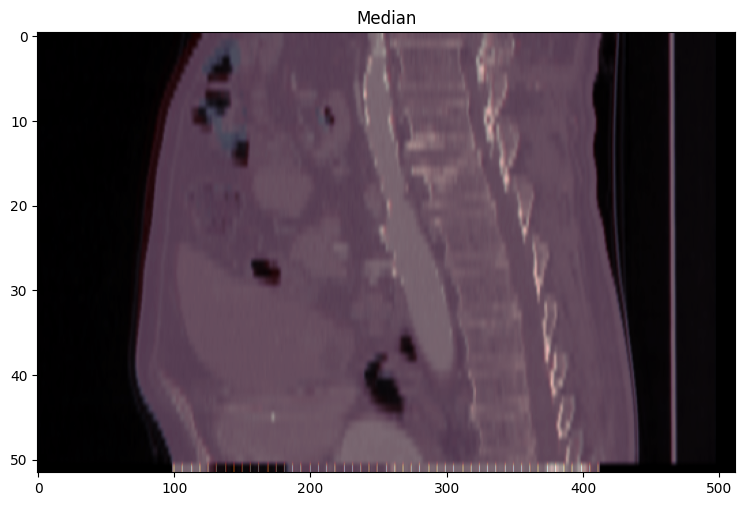

In [6]:
plt.figure(figsize=(9, 9))
plt.imshow(median_sagittal_plane(ref_volume_orig), cmap=matplotlib.colormaps['bone'], alpha=1.0, aspect=inp_pixel_dims[0]/inp_pixel_dims[1])
plt.imshow(median_sagittal_plane(inp_volume_orig), cmap=matplotlib.colormaps['gist_heat'], alpha=0.3, aspect=inp_pixel_dims[0]/inp_pixel_dims[1])
plt.title('Median')
plt.show()

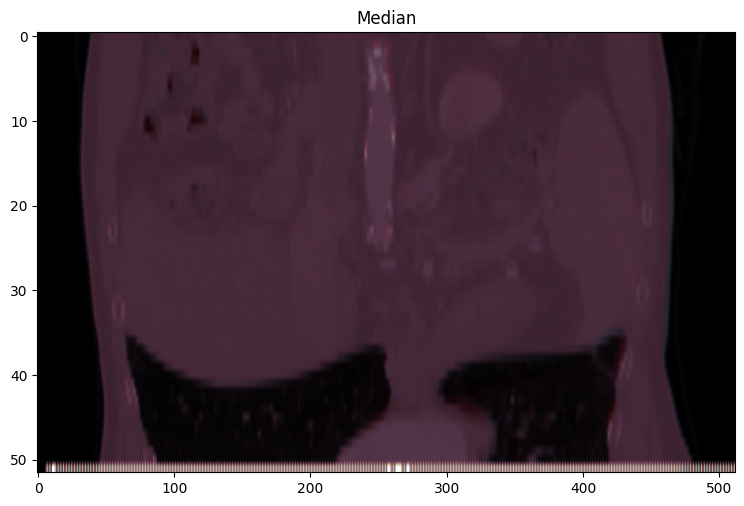

In [7]:
plt.figure(figsize=(9, 9))
plt.imshow(median_coronal_plane(ref_volume_orig), cmap=matplotlib.colormaps['bone'], alpha=1.0, aspect=inp_pixel_dims[0]/inp_pixel_dims[1])
plt.imshow(median_coronal_plane(inp_volume_orig), cmap=matplotlib.colormaps['gist_heat'], alpha=0.3, aspect=inp_pixel_dims[0]/inp_pixel_dims[1])
plt.title('Median')
plt.show()

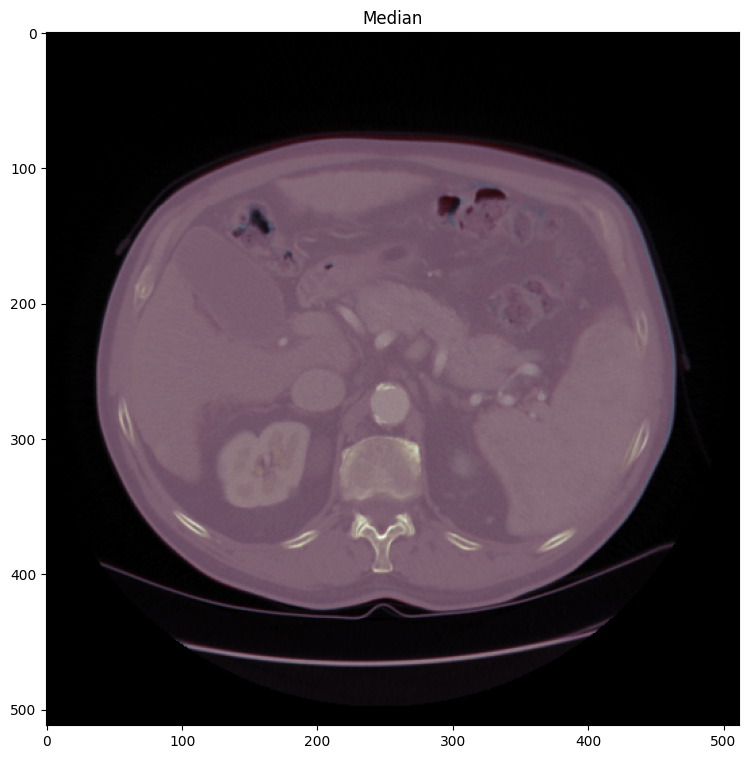

In [8]:
plt.figure(figsize=(9, 9))
plt.imshow(median_axial_plane(ref_volume_orig), cmap=matplotlib.colormaps['bone'], alpha=1.0)
plt.imshow(median_axial_plane(inp_volume_orig), cmap=matplotlib.colormaps['gist_heat'], alpha=0.2)
plt.title('Median')
plt.show()

This code normalizes the volumes for consistent intensity scaling and downsamples them in-plane to reduce data size and speed up registration. It also updates metadata to reflect new spacing and inspects the processed volumes to ensure correctness before registration.

In [9]:
# --- Preprocessing before registration ---
print("\nNormalizing volumes...")
# It's important to normalize the original volumes as well if they are used in final visualization,
# so they have the same value range as the transformed volume for consistent plotting.
ref_volume_norm_for_viz = min_max_normalize(ref_volume_orig)
inp_volume_norm = min_max_normalize(inp_volume_orig)

# --- Downsampling In-Plane (X,Y) for Efficiency ---
print("\nDownsampling in-plane (Y,X) dimensions for efficiency...")
downsample_factor_yx = 2 

# No need to pre-calculate shape after downsampling, zoom handles it
ref_downsample_zoom = (1.0, 1.0/downsample_factor_yx, 1.0/downsample_factor_yx)
inp_downsample_zoom = (1.0, 1.0/downsample_factor_yx, 1.0/downsample_factor_yx)

ref_volume_downsampled = zoom(ref_volume_norm_for_viz, ref_downsample_zoom, order=1, mode='nearest')
inp_volume_downsampled = zoom(inp_volume_norm, inp_downsample_zoom, order=1, mode='nearest')

ref_meta_downsampled = ModifiedMetadata(
    ref_meta_orig,
    [ref_meta_orig.PixelSpacing[0] * downsample_factor_yx, ref_meta_orig.PixelSpacing[1] * downsample_factor_yx],
    ref_meta_orig.SliceThickness
)
inp_meta_downsampled = ModifiedMetadata(
    inp_meta_orig,
    [inp_meta_orig.PixelSpacing[0] * downsample_factor_yx, inp_meta_orig.PixelSpacing[1] * downsample_factor_yx],
    inp_meta_orig.SliceThickness
)

inspect_volume(ref_volume_downsampled, ref_meta_downsampled, "Reference Volume (Downsampled & Normalized)")
inspect_volume(inp_volume_downsampled, inp_meta_downsampled, "Input Volume (Downsampled & Normalized)")


Normalizing volumes...

Downsampling in-plane (Y,X) dimensions for efficiency...

=== Reference Volume (Downsampled & Normalized) Volume Information ===
Shape (z,y,x): (52, 256, 256)
Data type: float64
Value range: 0.0 to 1.0
Pixel spacing (y,x): [1.609376, 1.609376] mm
Slice thickness: 5.000000 mm
First slice position: [-184.955, -237.634, -342.5]

=== Input Volume (Downsampled & Normalized) Volume Information ===
Shape (z,y,x): (52, 256, 256)
Data type: float64
Value range: 0.0 to 1.0
Pixel spacing (y,x): [1.609376, 1.609376] mm
Slice thickness: 5.000000 mm
First slice position: [-185.76, -236.829, -341.75]


This step resamples the downsampled volumes to have isotropic voxel spacing (equal spacing in all three dimensions), which improves accuracy in gradient calculations and registration by removing directional bias in voxel size

In [10]:
# --- Resampling to Isotropic Voxel Gradients (using the downsampled volumes) ---
print("\nResampling volumes to isotropic resolution...")
target_spacing_mm = 1.0 

ref_current_spacing_after_downsample = np.array([ref_meta_downsampled.SliceThickness,
                                                 ref_meta_downsampled.PixelSpacing[0],
                                                 ref_meta_downsampled.PixelSpacing[1]])
inp_current_spacing_after_downsample = np.array([inp_meta_downsampled.SliceThickness,
                                                 inp_meta_downsampled.PixelSpacing[0],
                                                 inp_meta_downsampled.PixelSpacing[1]])

ref_zoom_factors_isotropic = ref_current_spacing_after_downsample / target_spacing_mm
inp_zoom_factors_isotropic = inp_current_spacing_after_downsample / target_spacing_mm

ref_volume_resampled = zoom(ref_volume_downsampled, ref_zoom_factors_isotropic, order=1, mode='nearest')
inp_volume_resampled = zoom(inp_volume_downsampled, inp_zoom_factors_isotropic, order=1, mode='nearest')

ref_meta_resampled = ModifiedMetadata(
    ref_meta_orig, 
    [target_spacing_mm, target_spacing_mm],
    target_spacing_mm
)
inp_meta_resampled = ModifiedMetadata(
    inp_meta_orig,
    [target_spacing_mm, target_spacing_mm],
    target_spacing_mm
)

inspect_volume(ref_volume_resampled, ref_meta_resampled, "Reference Volume (Final Preprocessed)")
inspect_volume(inp_volume_resampled, inp_meta_resampled, "Input Volume (Final Preprocessed)")


Resampling volumes to isotropic resolution...

=== Reference Volume (Final Preprocessed) Volume Information ===
Shape (z,y,x): (260, 412, 412)
Data type: float64
Value range: 0.0 to 1.0
Pixel spacing (y,x): [1.0, 1.0] mm
Slice thickness: 1.0 mm
First slice position: [-184.955, -237.634, -342.5]

=== Input Volume (Final Preprocessed) Volume Information ===
Shape (z,y,x): (260, 412, 412)
Data type: float64
Value range: 0.0 to 1.0
Pixel spacing (y,x): [1.0, 1.0] mm
Slice thickness: 1.0 mm
First slice position: [-185.76, -236.829, -341.75]


# Step 3 - Coregistration

This step performs coregistration of two 3D volumes ( ref_volume_resampled and inp_volume_resampled) by aligning them based on their intensity gradients instead of their raw pixel intensities. Since pixel intensities can vary significantly due to different imaging conditions, using gradients—which highlight edges and structural boundaries—provides a more reliable and consistent feature for alignment. The process starts by smoothing both volumes to reduce noise, then calculating their 3D intensity gradients and the resulting gradient magnitudes, which are normalized for consistency. To initialize the alignment, the physical centroids of the original volumes are computed, giving a reasonable starting point for the transformation parameters. The transformation includes translation, rotation, and scaling, and the optimization uses a least-squares method to iteratively adjust these parameters for the best alignment. 

In [11]:
# --- Perform Coregistration ---
print("\nInitiating gradient-based coregistration...")
optimized_result = coregister_volumes_gradient_optimized(
    ref_volume_resampled, ref_meta_resampled, 
    inp_volume_resampled, inp_meta_resampled
)

print("\n--- Optimization Summary ---")
print(f"Optimization Status: {optimized_result.message}")
print(f"Number of function evaluations: {optimized_result.nfev}")
print(f"Final cost (0.5 * sum(residuals^2)): {optimized_result.cost:.4f}")
print(f"Optimized Parameters (scaled [0,1]): {str_floats(optimized_result.x)}")


Initiating gradient-based coregistration...

Preparing volumes for gradient-based registration...
Calculating centroids for initial guess (using original physical metadata for accuracy)...
Reference Volume Centroid (x,y,z): (21.84, -35.02, -211.95) mm
Input Volume Centroid (x,y,z): (21.89, -33.67, -210.22) mm

Initial Parameters for Optimization (Scaled for [0,1] range - Identity Transform):
  Translation (t1,t2,t3): (0.50, 0.50, 0.50)
  Rotation Axis (v1,v2,v3): (0.00, 0.00, 1.00)
  Rotation Angle (param): 0.00
  Scaling (s1,s2,s3): (1.00, 1.00, 1.00)

Starting gradient-based optimization with least_squares...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5074e+04                                    1.72e+06    
       1              2         1.1952e+04      3.12e+03       1.99e-02       3.28e+05    
       2              3         1.1385e+04      5.67e+02       1.07e+00       5.08e+05    
       3        

# Step 4 - Apply the optimized transformation
This step applies the optimized rigid transformation parameters, obtained from the previous registration process, to the input volume. Using the rigid_transformation function, it warps the resampled input volume to align spatially with the reference volume based on the best-fit translation, rotation, and scaling found during optimization. This results in a transformed input volume that should be better aligned for further analysis or visualization.


First, the translation values are scaled to a physical range and applied as shifts to the volume. For rotation, the function calculates the center of the volume to serve as the pivot point and normalizes the rotation axis vector. It then creates a quaternion to represent the rotation, which is converted into a rotation matrix. Quaternions are used because they provide a stable and efficient way to handle 3D rotations without problems like gimbal lock that can occur with other representations such as Euler angles. The rotation matrix is applied to the volume using an affine transformation around its center. After rotation, the volume is scaled along each axis according to the scaled scaling parameters. Finally, the transformed volume is padded or cropped to match the shape of the reference volume, ensuring consistent output size. 

In [12]:
# --- Apply the optimized transformation ---
print("\nApplying optimized transformation to input volume...")
transformed_inp_volume = rigid_transformation(
    inp_volume_resampled, optimized_result.x, ref_volume_resampled.shape
)


Applying optimized transformation to input volume...


the final spatial adjustment applied to align the input volume with the reference volume. The translation indicates a small shift of approximately 0.97 mm, 0.46 mm, and 0.81 mm along the x, y, and z axes, respectively. The rotation occurs around the x-axis with a very slight angle of 0.16 degrees, suggesting minimal rotational adjustment. Scaling remains unchanged at 1.00 along all axes, meaning no resizing was necessary. Overall, these parameters reflect a subtle but precise correction to improve alignment.

In [13]:
# --- Interpret optimized parameters in physical units ---
t1_opt, t2_opt, t3_opt, v1_opt, v2_opt, v3_opt, angle_param_opt, s1_opt, s2_opt, s3_opt = optimized_result.x

optimized_tx_mm = (t1_opt * 40) - 20
optimized_ty_mm = (t2_opt * 40) - 20
optimized_tz_mm = (t3_opt * 40) - 20

optimized_angle_rads = angle_param_opt * (2 * np.pi)
optimized_angle_degrees = np.degrees(optimized_angle_rads)

optimized_s1 = (s1_opt * 0.1) + 0.9
optimized_s2 = (s2_opt * 0.1) + 0.9
optimized_s3 = (s3_opt * 0.1) + 0.9

axis_norm = math.sqrt(v1_opt**2 + v2_opt**2 + v3_opt**2)
if axis_norm < 1e-7:
    optimized_rot_axis = (0.0, 0.0, 0.0)
else:
    optimized_rot_axis = (v1_opt / axis_norm, v2_opt / axis_norm, v3_opt / axis_norm)

print("\n--- Optimized Transformation Parameters (Physical Units) ---")
print(f"  Translation (x,y,z): ({optimized_tx_mm:.2f}, {optimized_ty_mm:.2f}, {optimized_tz_mm:.2f}) mm")
print(f"  Rotation Axis (x,y,z): ({optimized_rot_axis[0]:.2f}, {optimized_rot_axis[1]:.2f}, {optimized_rot_axis[2]:.2f})")
print(f"  Rotation Angle: {optimized_angle_degrees:.2f} degrees")
print(f"  Scaling (x,y,z): ({optimized_s1:.2f}, {optimized_s2:.2f}, {optimized_s3:.2f})")


--- Optimized Transformation Parameters (Physical Units) ---
  Translation (x,y,z): (0.97, 0.46, 0.81) mm
  Rotation Axis (x,y,z): (1.00, 0.00, 0.00)
  Rotation Angle: 0.16 degrees
  Scaling (x,y,z): (1.00, 1.00, 1.00)


This visualization compares the reference volume and the transformed input volume after coregistration by plotting the same planes from both volumes in a single figure. The reference volume is displayed using a grayscale colormap (bone) with 70% opacity, while the transformed input volume is overlaid using a heatmap colormap (gist_heat) at 30% opacity. The observation shows that the volumes are practically aligned, as they were already close before coregistration, and the registration process resulted in only tiny adjustments.

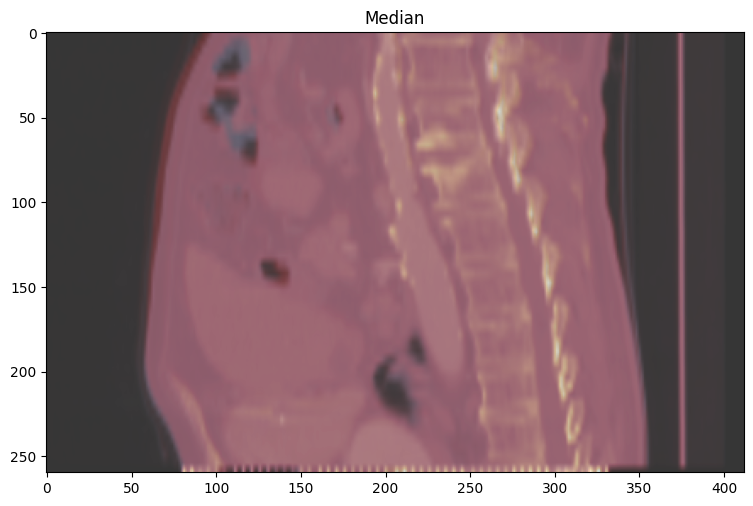

In [14]:
plt.figure(figsize=(9, 9))
plt.imshow(median_sagittal_plane(ref_volume_resampled), cmap=matplotlib.colormaps['bone'], alpha=0.7)
plt.imshow(median_sagittal_plane(transformed_inp_volume), cmap=matplotlib.colormaps['gist_heat'], alpha=0.3)
plt.title('Median')
plt.show()

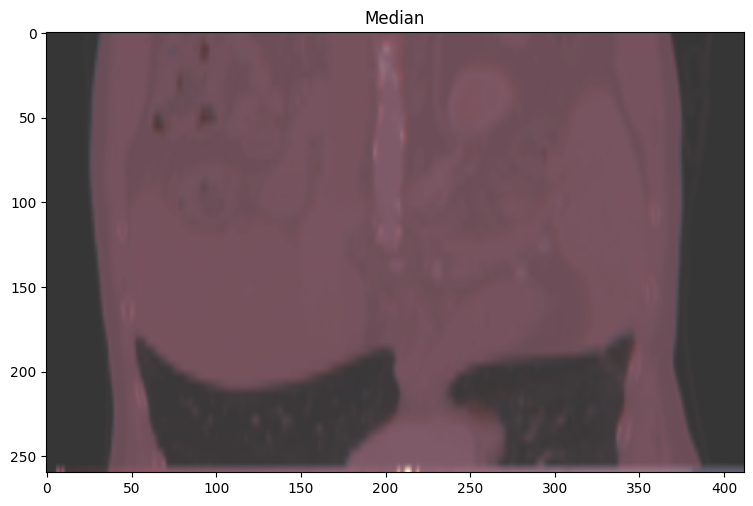

In [15]:
plt.figure(figsize=(9, 9))
plt.imshow(median_coronal_plane(ref_volume_resampled), cmap=matplotlib.colormaps['bone'], alpha=0.7)
plt.imshow(median_coronal_plane(transformed_inp_volume), cmap=matplotlib.colormaps['gist_heat'], alpha=0.3)
plt.title('Median')
plt.show()

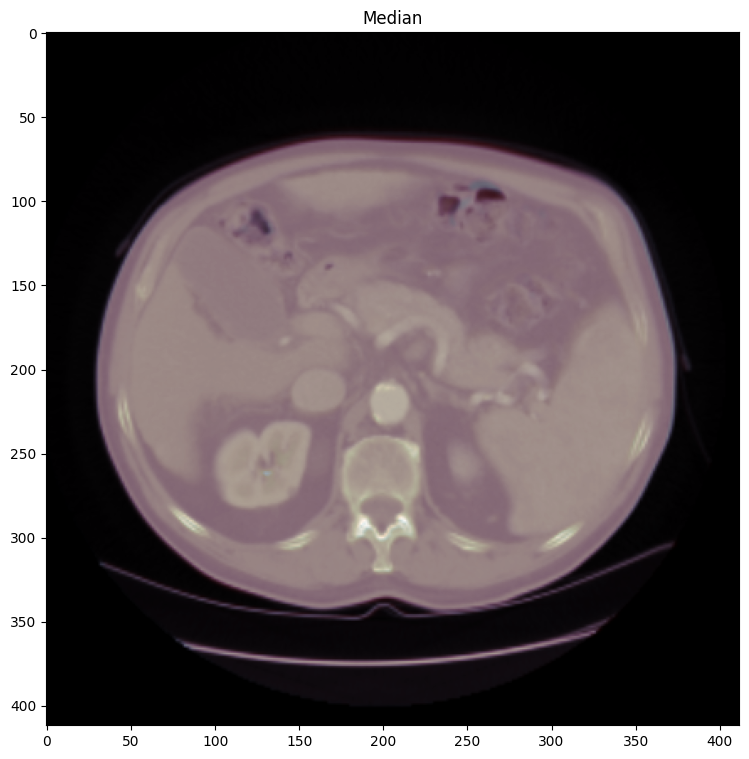

In [16]:
plt.figure(figsize=(9, 9))
plt.imshow(median_axial_plane(ref_volume_resampled), cmap=matplotlib.colormaps['bone'], alpha=1.0)
plt.imshow(median_axial_plane(transformed_inp_volume), cmap=matplotlib.colormaps['gist_heat'], alpha=0.2)
plt.title('Median')
plt.show()

# Step 5 - quantitative assessment
This step performs a quantitative assessment of the registration quality by comparing the reference volume and the transformed input volume after coregistration. It first calculates the gradient magnitudes of both volumes, which highlight edges and structural details less sensitive to intensity differences. Then, it computes the sum of squared differences (SSD) between these gradient magnitudes as a measure of similarity—the lower the SSD, the better the alignment.

In [17]:
# Calculate gradient magnitude of the ALIGNED input volume
ref_volume_resampled_gradient_magnitude = calculate_gradient_magnitude_volume(ref_volume_resampled)
transformed_inp_volume_gradient_magnitude = calculate_gradient_magnitude_volume(transformed_inp_volume)

final_ssd_gradients = np.sum((ref_volume_resampled_gradient_magnitude.flatten() - transformed_inp_volume_gradient_magnitude.flatten())**2)
final_mi_volumes = mutual_information(ref_volume_resampled, transformed_inp_volume)

print(f"Final Gradient SSD: {final_ssd_gradients:.4f}")
print(f"Final Mutual Information (Volume Intensities): {final_mi_volumes:.4f}")

Final Gradient SSD: 34718.4219
Final Mutual Information (Volume Intensities): 1.6429


The Mutual Information (MI) increased from 1.4568 to 1.6429, indicating improved statistical dependence and therefore better overall intensity alignment between the reference and transformed input volumes, the Gradient Sum of Squared Differences (SSD) significantly worsened, increasing from 6991.43 to 34718.42. this is likely attributable to the difference in the image spaces where the "before" and "after" metrics are computed. Specifically, the "before" SSD was calculated on the original, anisotropic, volume, while the "after" SSD operated on volumes that were resampled to an isotropic 1.0mm resolution. 

# 2- Visualize the Liver region on the input image space

Since the liver segmentation mask is aligned with the reference volume, it can be overlaid on the input volume after applying the inverse of the coregistration transformation, allowing for anatomical alignment assessment. This enables evaluation of how well the input volume has been registered to the reference by examining the correspondence of anatomical structures, such as the liver, in both volumes. The printed shape and data type provide a quick verification that the mask has been loaded correctly and is compatible with further processing or visualization steps.

In [19]:
# Load the liver segmentation mask from the reference image space
liver_seg_path = data_dir / '11_AP_Ax5.00mm_ManualROI_Liver.dcm'
liver_seg_dcm = pydicom.dcmread(liver_seg_path)
liver_seg_mask_orig = liver_seg_dcm.pixel_array
print(f"\nLoaded Liver Segmentation Mask. Shape: {liver_seg_mask_orig.shape}, Data Type: {liver_seg_mask_orig.dtype}")


Loaded Liver Segmentation Mask. Shape: (26, 512, 512), Data Type: uint8


To prepare for the liver mask-based evaluation of registration quality, the reference liver segmentation mask is first normalized using min-max scaling. This ensures consistent value ranges across all image and mask data used in the workflow

In [20]:
liver_seg_mask_normalized = min_max_normalize(liver_seg_mask_orig)

The liver segmentation mask is downsampled using the same factors applied to the input volume to maintain consistency in spatial resolution. Nearest-neighbor interpolation (order=0) ensures the mask remains binary

In [ ]:
# Apply the same downsampling as the input volume
liver_seg_mask_downsampled = zoom(liver_seg_mask_normalized, ref_downsample_zoom, order=0, mode='nearest')
print(f"Liver Mask after downsampling: {liver_seg_mask_downsampled.shape}")

Liver Mask after downsampling: (26, 256, 256)


The liver mask is further resampled to match the isotropic resolution of the input volume, using the same zoom factors applied earlier. Nearest-neighbor interpolation (order=0) preserves the binary nature of the mask.

In [ ]:
# Apply the same isotropic resampling as the input volume
liver_seg_mask_resampled = zoom(liver_seg_mask_downsampled, ref_zoom_factors_isotropic, order=0, mode='nearest')
print(f"Liver Mask after resampling to isotropic: {liver_seg_mask_resampled.shape}")

Liver Mask after resampling to isotropic: (130, 412, 412)


This code applies the inverse of the previously estimated rigid transformation to the resampled liver segmentation mask. The goal is to bring the mask—originally aligned with the reference volume—into the input volume’s space for direct comparison. The shape of the transformed mask is printed to confirm that the operation preserved the expected dimensions.

In [23]:
print("\nApplying inverse rigid transformation to liver segmentation mask...")
transformed_liver_mask_resampled_space = inverse_rigid_transformation(
    liver_seg_mask_resampled, optimized_result.x, inp_volume_resampled.shape
)
print(f"Transformed Liver Mask shape: {transformed_liver_mask_resampled_space.shape}")


Applying inverse rigid transformation to liver segmentation mask...
Transformed Liver Mask shape: (260, 412, 412)


The visualization shows the transformed liver segmentation mask accurately overlaid on the input volume’s planes. The liver region aligns well with the anatomical structures in the grayscale image, indicating that the registration and inverse transformation have successfully mapped the liver mask into the input volume space. Overall, The result confirms satisfactory alignment of the liver segmentation after coregistration, as the transformed mask closely matches the anatomical structures in the input volume across the visualized planes


Visualizing liver region in input volume space...


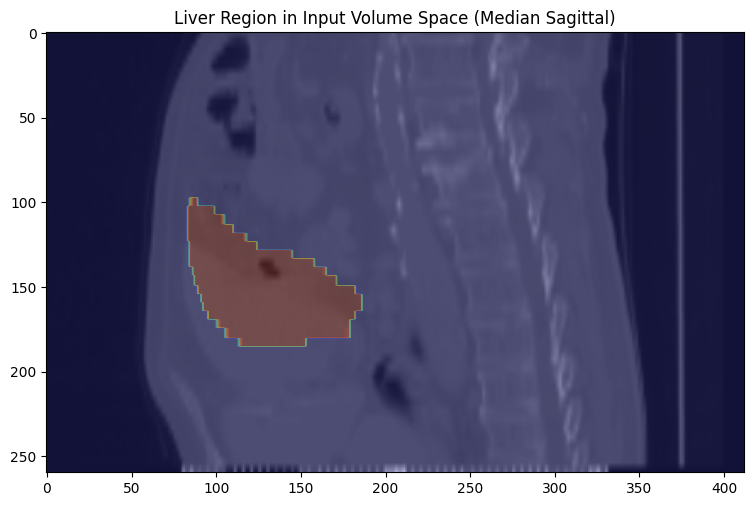

In [24]:
# Visualize the transformed liver mask overlaid on the input volume (resampled)
print("\nVisualizing liver region in input volume space...")
plt.figure(figsize=(9, 9))
plt.imshow(median_sagittal_plane(inp_volume_resampled), cmap=matplotlib.colormaps['gray'], alpha=0.9)
plt.imshow(median_sagittal_plane(transformed_liver_mask_resampled_space), cmap=matplotlib.colormaps['jet'], alpha=0.3)
plt.title('Liver Region in Input Volume Space (Median Sagittal)')
plt.show()

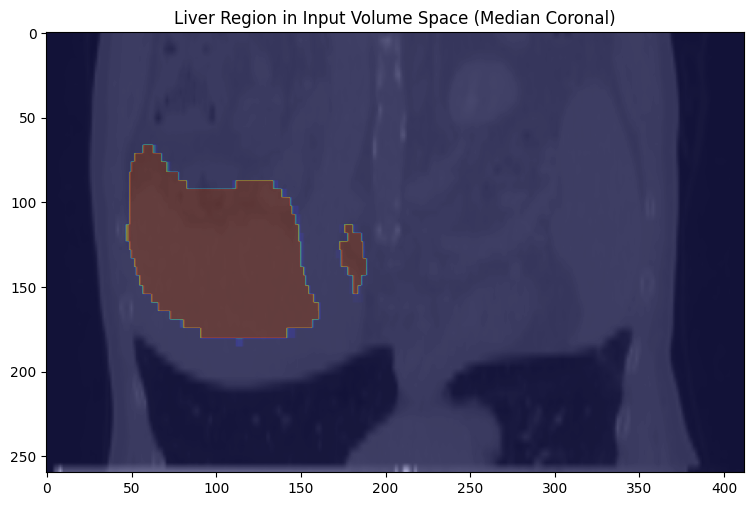

In [25]:
plt.figure(figsize=(9, 9))
plt.imshow(median_coronal_plane(inp_volume_resampled), cmap=matplotlib.colormaps['gray'], alpha=0.9)
plt.imshow(median_coronal_plane(transformed_liver_mask_resampled_space), cmap=matplotlib.colormaps['jet'], alpha=0.3)
plt.title('Liver Region in Input Volume Space (Median Coronal)')
plt.show()

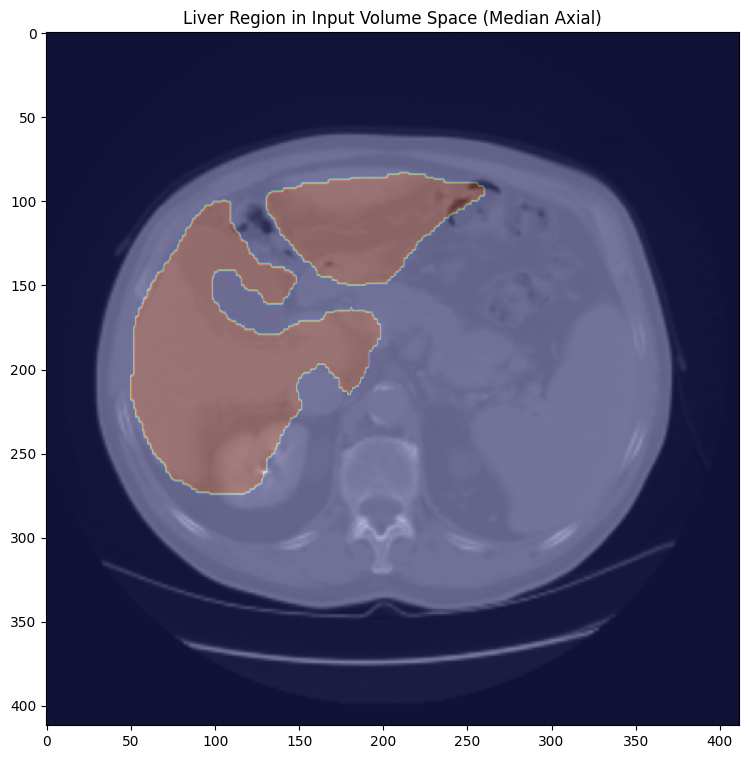

In [26]:
plt.figure(figsize=(9, 9))
plt.imshow(median_axial_plane(inp_volume_resampled), cmap=matplotlib.colormaps['gray'], alpha=0.9)
plt.imshow(median_axial_plane(transformed_liver_mask_resampled_space), cmap=matplotlib.colormaps['jet'], alpha=0.3)
plt.title('Liver Region in Input Volume Space (Median Axial)')
plt.show()

# quantitative assessment of Visualizing the Liver region on the input image space

This code is done to quantitatively evaluate how well the liver segmentation mask, transformed by the registration process, aligns with the ground truth liver mask of the input image. The key goal is to measure the overlap and similarity between the two masks to assess the accuracy and effectiveness of the registration.

The printed shapes confirm that both masks have exactly the same dimensions, which is essential for a valid comparison. The high Dice coefficient (0.9704) and Jaccard index (0.9425) indicate a very strong spatial overlap between the transformed mask and the ground truth, meaning the registration successfully aligned the liver regions. The sensitivity (0.9692) shows that most of the true liver region in the input mask is correctly identified in the transformed mask, while the near-perfect specificity (0.9990) means almost all non-liver regions are correctly excluded.

In [ ]:
# 1. Load the ground truth liver mask for the input image 
try:
    input_liver_seg_path = data_dir / '11_AP_Ax5.00mm_ManualROI_Liver.dcm' # This needs to be your actual path
    input_liver_seg_dcm = pydicom.dcmread(input_liver_seg_path)
    input_liver_mask_orig = input_liver_seg_dcm.pixel_array
except FileNotFoundError:
    print(f"Error: Input liver segmentation not found at {input_liver_seg_path}.")


# 2. Preprocess the input liver mask exactly as did for the reference liver mask

combined_zoom_factors = (
    ref_downsample_zoom[0] * ref_zoom_factors_isotropic[0],
    ref_downsample_zoom[1] * ref_zoom_factors_isotropic[1],
    ref_downsample_zoom[2] * ref_zoom_factors_isotropic[2]
)

# Apply the combined zoom
input_liver_mask_resampled_temp = zoom(
    input_liver_mask_orig.astype(float),
    combined_zoom_factors,
    # Nearest neighbor for binary masks
    order=0  
)

# Force the shape to match inp_volume_resampled.shape 
# This is the critical step to ensure matching dimensions for comparison.
input_liver_mask_resampled = center_pad(input_liver_mask_resampled_temp, inp_volume_resampled.shape)


# 3. Ensure both masks are binary and have the same shape
transformed_liver_mask_binary = (transformed_liver_mask_resampled_space > 0.5).astype(np.uint8)
input_liver_mask_binary = (input_liver_mask_resampled > 0.5).astype(np.uint8) 

# Debugging prints to see the shapes before assertion
print(f"Shape of transformed_liver_mask_binary: {transformed_liver_mask_binary.shape}")
print(f"Shape of input_liver_mask_binary: {input_liver_mask_binary.shape}")

# The assertion should now pass if center_pad works as expected
assert transformed_liver_mask_binary.shape == input_liver_mask_binary.shape, "Masks must have same dimensions after explicit padding."

# 4. Calculate overlap metrics
def calculate_dice(mask1, mask2):
    # Handle the case where masks might be empty to avoid division by zero
    if mask1.sum() == 0 and mask2.sum() == 0:
        return 1.0 # Perfect overlap if both are empty
    intersection = np.logical_and(mask1, mask2)
    return 2. * intersection.sum() / (mask1.sum() + mask2.sum())

def calculate_jaccard(mask1, mask2):
    # Handle the case where masks might be empty to avoid division by zero
    union = np.logical_or(mask1, mask2)
    if union.sum() == 0:
        return 1.0 # Perfect overlap if both are empty
    intersection = np.logical_and(mask1, mask2)
    return intersection.sum() / union.sum()

dice_score = calculate_dice(transformed_liver_mask_binary, input_liver_mask_binary)
jaccard_score = calculate_jaccard(transformed_liver_mask_binary, input_liver_mask_binary)

print(f"\nRegistration Quality Metrics:")
print(f"Dice Coefficient: {dice_score:.4f}")
print(f"Jaccard Index: {jaccard_score:.4f}")

# 5. Additional metrics 
def calculate_sensitivity(mask_pred, mask_true):
    # Handle empty true mask
    if mask_true.sum() == 0:
        return 1.0 if mask_pred.sum() == 0 else 0.0 
    intersection = np.logical_and(mask_pred, mask_true)
    return intersection.sum() / mask_true.sum()

def calculate_specificity(mask_pred, mask_true):
    true_negative_region = np.logical_not(mask_true) 
    if true_negative_region.sum() == 0:
        return 1.0 if np.logical_not(mask_pred).sum() == 0 else 0.0 
    
    true_negative = np.logical_and(np.logical_not(mask_pred), true_negative_region)
    return true_negative.sum() / true_negative_region.sum()


sensitivity = calculate_sensitivity(transformed_liver_mask_binary, input_liver_mask_binary)
specificity = calculate_specificity(transformed_liver_mask_binary, input_liver_mask_binary)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Shape of transformed_liver_mask_binary: (260, 412, 412)
Shape of input_liver_mask_binary: (260, 412, 412)

Registration Quality Metrics:
Dice Coefficient: 0.9704
Jaccard Index: 0.9425
Sensitivity (Recall): 0.9692
Specificity: 0.9990


# Conclusion

This pipeline performs rigid registration between two volumetric images, aligning their anatomical structures and quantitatively evaluating the alignment using both intensity-based and segmentation-based metrics. By combining image resampling, spatial transformation, and overlap analysis of liver masks, it ensures accurate spatial correspondence. The high similarity scores and positive visual assessments confirm that the registration effectively aligns the input volume to the reference. However, there remains room for further fine-tuning and improvement, particularly in the coregistration step and transformation parameters, to achieve more precise alignment.